<a href="https://colab.research.google.com/github/bloody-rum09/Open_Project_Winter_2025/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 Assignment: Quantum Measurement Dataset Foundations

Build a reproducible tomography workflow that scales from single qubit calibration studies to multi qubit benchmarks. Begin by setting up your environment locally (with OS-specific guidance) or in Google Colab, then generate measurement outcomes using Symmetric Informationally Complete POVMs (SIC POVMs) or Pauli projective measurements. Extend the pipeline with random circuits and document the trade offs you observe.

**Task roadmap**
1. Set up and document your environment.
2. Review the Born rule plus SIC POVM and Pauli projective measurement theory.
3. Generate and visualize QST datasets.
4. Perform single qubit tomography
5. Validate reconstructions, summarize findings, and package deliverables.

> Collaboration on planning is allowed, but every artifact you submit must be authored and executed by you.

## Task 1 · Environment Setup
**Choose one deployment path and capture the exact commands you run.**

### Local virtual environment (recommended)
- **macOS / Linux:**
  1. `python3 -m venv .venv`
  2. `source .venv/bin/activate`
  3. `python -m pip install --upgrade pip wheel`
- **Windows (PowerShell):**
  1. `py -3 -m venv .venv`
  2. `.venv\Scripts\Activate.ps1`
  3. `python -m pip install --upgrade pip wheel`

### Google Colab fallback
- Create a new notebook at https://colab.research.google.com and enable a GPU if available.
- Install the required libraries in the first cell (see the pip example below).
- Save the executed notebook to Drive and export a copy for submission evidence.

### Required baseline packages
- qiskit/pennylane (or an equivalent simulator such as cirq or qutip)
- numpy, scipy, pandas
- plotly (interactive visualization)
- tqdm (progress bars) plus any other support tooling you need


In [ ]:
# Run inside your activated virtual environment or a Colab cell.
# Feel free to adjust versions based on your simulator choice.
!python -m pip install  pennylane numpy scipy pandas plotly tqdm nbformat


## Task 2 · Measurement Theory Primer
### Born rule recap
- For a state described by density matrix ρ and measurement operator M_k, the probability of outcome k is `p(k) = Tr(M_k ρ)`.
- For projective measurements, `M_k = P_k` with `P_k^2 = P_k` and `∑_k P_k = I`. For POVMs, `M_k = E_k` where each `E_k` is positive semi-definite and `∑_k E_k = I`.
- Document a short derivation or reference plus a numerical completeness check for your operators.

### SIC POVM vs. Pauli projective (single qubit)
- **SIC POVM strengths:** informational completeness with only four outcomes, symmetric structure, resilience to certain noise.
- **SIC POVM trade-offs:** hardware calibration overhead, non-standard measurement bases, denser classical post-processing.
- **Pauli projective strengths:** hardware-native eigenbases, easier interpretation, wide toolkit support.
- **Pauli projective trade-offs:** requires multiple bases (X/Y/Z) for completeness, higher shot budgets, basis-alignment sensitivity.

Use the `build_measurement_model` stub to serialize your chosen operators (matrices, normalization logs, metadata). Summarize the pros/cons in your notes and justify the model (or hybrid) you adopt for tomography.

SHORT DERIVATION:
For projective measurements, where M_k = |k><k|, Born rule follows directly from the inner product formulation of quantum mechanics, where probability of observing state |k> from a pure state |ψ> is |<k|ψ>|**2.

In [ ]:
import numpy as np

# Density matrix for |0>
rho = np.array([[1, 0],
                [0, 0]])

# Projective measurement operators (Pauli-Z)
M0 = np.array([[1, 0],
               [0, 0]])
M1 = np.array([[0, 0],
               [0, 1]])
measurement_ops = [M0, M1]

# Born rule probabilities
p0 = np.trace(M0 @ rho)
p1 = np.trace(M1 @ rho)

# expected output- 1 0 1
print(p0, p1, p0 + p1)
# expected to return true
print(np.allclose(M0 + M1, np.eye(2)))

1 0 1
True


PAULI PROJECTIVE Vs. SIC POVMs (Single Qubit)
PAULI PROJECTIVE MEASUREMENTS
- Projective measurements performed in the eigenbases of the Pauli operators X,Y,Z.
- Each measurement yields 2 orthogonal outcomes.
- Informational completeness is obtained by combining results from multiple bases.

ADVANTAGES:
1. Hardware-native and widely supported in quantum platforms.
2. Simple interpretation of measurements outcomes and minimal calibration complexity.
3. Extreme tooling and theoritical support.

DISADVANTAGES
1. Requires measurements in multiple bases (X,Y,Z) for full state reconstruction.
2. Higher total shot budget to achieve comparable precision.
3. Sensitive to basis misalignment and systematic calibration errors.

SIC POVMs
- A generalized measurement described by four positive semidefinite operators for a single qubit.
- Measurement operators are symmetrically distributed in state space.
- Informational completeness is achieved using a single measurment setting.

ADVANTAGES
1. Achieves informational completeness with minimal no.of outcomes.
2. Symmetric structure leads to efficient and uniform state reconstruction.
3. Improved robustness to certain noise models.
4. Reduced no.of measurement configurations.

DISADVANTAGES
1. Requires non-standard measurement bases.
2. Increased experimental and calibration complexity.
3. Higher classical post-processing overhead.
4. Less commonly supported in standard quantum hardware toolchains.

Model Choice for this work
Selected approach: Pauli Projective Measurements
Justification:
- Interpretability and simplicity
- Compatability with standard hardware assumptions
- Suitable baseline for initial tomography implemetation.

### Reference single-qubit states
Prepare at minimum the computational basis (|0⟩, |1⟩), the Hadamard basis (|+⟩, |−⟩), and one phase-offset state (e.g., `( |0⟩ + i |1⟩ ) / √2`). Document how you synthesize each state in circuit form and store a textual or JSON summary of the gates used. You may optionally include mixed states by applying depolarizing or amplitude damping channels.

REFERENCE SINGLE QUBIT STATES
We define a set of single-qubit pure states that i will be using in this assignment which will be including:
- Computational Basis States (|0⟩, |1⟩).
- Hadamard basis (|+⟩, |−⟩).
- One phase-offset state ((|0⟩ + i |1⟩) / √2).


In [ ]:
# Computational basis states
import numpy as np
ket0 = np.array([[1.0], [0.0]])
ket1 = np.array([[0.0], [1.0]])

# Reference single-qubit states
states = {
    "|0>": ket0,
    "|1>": ket1,
    "|+>": (ket0 + ket1) / np.sqrt(2),
    "|->": (ket0 - ket1) / np.sqrt(2),
    "|0>+i|1>": (ket0 + 1j * ket1) / np.sqrt(2)
}


for name, state in states.items():
    norm = np.vdot(state, state)
    print(f"{name}:")
    print(state)
    print("Norm =", norm)
    print()


|0>:
[[1.]
 [0.]]
Norm = 1.0

|1>:
[[0.]
 [1.]]
Norm = 1.0

|+>:
[[0.70710678]
 [0.70710678]]
Norm = 0.9999999999999998

|->:
[[ 0.70710678]
 [-0.70710678]]
Norm = 0.9999999999999998

|0>+i|1>:
[[0.70710678+0.j        ]
 [0.        +0.70710678j]]
Norm = (0.9999999999999998+0j)



Circuit documentation

In [ ]:
# gate sequence for reference states
state_circuits = {
    "|0>": ["init"],
    "|1>": ["X"],
    "|+>": ["H"],
    "|->": ["X", "H"],
    "|0>+i|1>": ["H", "S"]
}

for state, gates in state_circuits.items():
    print(f'{state}: {gates}')



|0>: ['init']
|1>: ['X']
|+>: ['H']
|->: ['X', 'H']
|0>+i|1>: ['H', 'S']


Converting State Vectors Into Density Matrices

In [ ]:
density_matrices = {
    name: ket @ ket.conj().T
    for name, ket in states.items()
}

# checking validity of our density matrices
for name, rho in density_matrices.items():
    trace = np.trace(rho)
    hermitian = np.allclose(rho, rho.conj().T)
    print(f"{name}:")
    print(rho)
    print(f"Trace = {trace}, Hermitian = {hermitian}")
    print()


|0>:
[[1. 0.]
 [0. 0.]]
Trace = 1.0, Hermitian = True

|1>:
[[0. 0.]
 [0. 1.]]
Trace = 1.0, Hermitian = True

|+>:
[[0.5 0.5]
 [0.5 0.5]]
Trace = 0.9999999999999998, Hermitian = True

|->:
[[ 0.5 -0.5]
 [-0.5  0.5]]
Trace = 0.9999999999999998, Hermitian = True

|0>+i|1>:
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]
Trace = (0.9999999999999998+0j), Hermitian = True



In [ ]:
from typing import Dict, Any
import pathlib

def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    """
    Stub for constructing or loading the measurement operators you plan to use.
    Populate the return value with operator definitions, normalization checks, and metadata.
    """
    # TODO: implement SIC POVM or Pauli projective operator assembly here.
    raise NotImplementedError("..")

In [ ]:
import numpy as np

def build_measurement_model():
    # basis states
    ket0 = np.array([[1.0], [0.0]])
    ket1 = np.array([[0.0], [1.0]])

    ket_plus  = (ket0 + ket1) / np.sqrt(2)
    ket_minus = (ket0 - ket1) / np.sqrt(2)

    ket_ip = (ket0 + 1j * ket1) / np.sqrt(2)
    ket_im = (ket0 - 1j * ket1) / np.sqrt(2)

    # projectors
    Z = [ket0 @ ket0.conj().T, ket1 @ ket1.conj().T]
    X = [ket_plus @ ket_plus.conj().T, ket_minus @ ket_minus.conj().T]
    Y = [ket_ip @ ket_ip.conj().T, ket_im @ ket_im.conj().T]

    I = np.eye(2)

    measurement_model = {
        "measurement_type": "pauli_projective",
        "dimension": 2,
        "operators": {
            "X": X,
            "Y": Y,
            "Z": Z
        },
        "completeness_check": {
            "X": np.allclose(sum(X), I),
            "Y": np.allclose(sum(Y), I),
            "Z": np.allclose(sum(Z), I)
        },
        "notes": "Pauli X/Y/Z projective measurements for single-qubit tomography"
    }

    return measurement_model

model = build_measurement_model()


In [ ]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


In [ ]:
for name, rho in density_matrices.items():
    plot_density_matrix_histogram(
        rho,
        basis_labels=["|0>", "|1>"],
        title=f"Density matrix of {name}"
    )
    print(name, "trace:", np.trace(rho))
    print(name, "Hermitian:", np.allclose(rho, rho.conj().T))


|0> trace: 1.0
|0> Hermitian: True


|1> trace: 1.0
|1> Hermitian: True


|+> trace: 0.9999999999999998
|+> Hermitian: True


|-> trace: 0.9999999999999998
|-> Hermitian: True


|0>+i|1> trace: (0.9999999999999998+0j)
|0>+i|1> Hermitian: True


### Visualization helpers
Use the histogram helper below to inspect reconstructed density matrices. Include screenshots or exported HTML for a few representative states in your report.

In [ ]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")

In [ ]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )

## Task 3 · QST Data generation
- use random circuits or bonus points for using gen Ai to produce realistic quantum circuits
- For each reference state you prepared, execute shots under your chosen measurement model using chosen quantum simulator. Record raw counts and computed probabilities.
- Store measurement data (`single_qubit_<state>.npx` or `.npy`)

In [ ]:
!pip install qiskit qiskit-aer


In [ ]:
import numpy as np
from pathlib import Path

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.qasm3 import dumps


NUM_RANDOM_STATES = 20
CIRCUIT_DEPTH = 6
SHOTS = 1024

OUTPUT_DIR = Path("qst_data/measurements")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

simulator = AerSimulator()

# generating random circuits
def random_single_qubit_circuit(depth: int) -> QuantumCircuit:
    qc = QuantumCircuit(1)
    for _ in range(depth):
        theta = np.random.uniform(0, 2 * np.pi)
        phi   = np.random.uniform(0, 2 * np.pi)
        lam   = np.random.uniform(0, 2 * np.pi)
        qc.u(theta, phi, lam, 0)
    return qc


def add_measurement(qc: QuantumCircuit, basis: str) -> QuantumCircuit:
    qc = qc.copy()

    if basis == "X":
        qc.h(0)
    elif basis == "Y":
        qc.sdg(0)
        qc.h(0)
    elif basis == "Z":
        pass
    else:
        raise ValueError("Invalid measurement basis")

    qc.measure_all()
    return qc


def run_qst_experiment(qc: QuantumCircuit):
    bases = ["X", "Y", "Z"]
    raw_counts = {}
    probabilities = {}

    for basis in bases:
        meas_circuit = add_measurement(qc, basis)
        tqc = transpile(meas_circuit, simulator)
        result = simulator.run(tqc, shots=SHOTS).result()
        counts = result.get_counts()

        raw_counts[basis] = counts
        probabilities[basis] = {k: v / SHOTS for k, v in counts.items()}

    return raw_counts, probabilities


def save_npy(idx, raw_counts, probabilities, circuit):
    data = {
        "id": idx,
        "shots": SHOTS,
        "raw_counts": raw_counts,
        "probabilities": probabilities,
        "circuit_qasm3": dumps(circuit),
    }

    np.save(
        OUTPUT_DIR / f"single_qubit_rand_{idx:03d}.npy",
        data,
        allow_pickle=True
    )

def save_npz(idx, raw_counts, probabilities, circuit):
    np.savez(
        OUTPUT_DIR / f"single_qubit_rand_{idx:03d}.npz",
        id=idx,
        shots=SHOTS,
        raw_counts=raw_counts,
        probabilities=probabilities,
        circuit_qasm3=dumps(circuit),
    )


if __name__ == "__main__":
    for i in range(NUM_RANDOM_STATES):
        qc = random_single_qubit_circuit(CIRCUIT_DEPTH)
        raw_counts, probabilities = run_qst_experiment(qc)

        save_npy(i, raw_counts, probabilities, qc)
        save_npz(i, raw_counts, probabilities, qc)

        print(f"[✓] Saved random state {i}")

    print("\nQST random-circuit dataset generation complete.")


[✓] Saved random state 0
[✓] Saved random state 1
[✓] Saved random state 2
[✓] Saved random state 3
[✓] Saved random state 4
[✓] Saved random state 5
[✓] Saved random state 6
[✓] Saved random state 7
[✓] Saved random state 8
[✓] Saved random state 9
[✓] Saved random state 10
[✓] Saved random state 11
[✓] Saved random state 12
[✓] Saved random state 13
[✓] Saved random state 14
[✓] Saved random state 15
[✓] Saved random state 16
[✓] Saved random state 17
[✓] Saved random state 18
[✓] Saved random state 19

QST random-circuit dataset generation complete.


In [241]:
import numpy as np
from pathlib import Path
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Directory to save reconstructed density matrices
OUTPUT_DIR = Path("qst_data/reconstructed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
I2 = np.eye(2, dtype=complex)

SHOTS = 1024
simulator = AerSimulator()

# Reference states from Task 2
ket0 = np.array([[1.0], [0.0]])
ket1 = np.array([[0.0], [1.0]])
states = {
    "|0>": ket0,
    "|1>": ket1,
    "|+>": (ket0 + ket1)/np.sqrt(2),
    "|->": (ket0 - ket1)/np.sqrt(2),
    "|0>+i|1>": (ket0 + 1j*ket1)/np.sqrt(2)
}

# Gate circuits to prepare the reference states
state_circuits = {
    "|0>": ["init"],
    "|1>": ["X"],
    "|+>": ["H"],
    "|->": ["X", "H"],   # could also be ["H","X"]
    "|0>+i|1>": ["H", "S"]
}

# Function to create Qiskit circuit for reference state
def build_circuit_from_gates(gates):
    qc = QuantumCircuit(1)
    for g in gates:
        if g == "X":
            qc.x(0)
        elif g == "H":
            qc.h(0)
        elif g == "S":
            qc.s(0)
        elif g == "init":
            pass
    return qc

# Add measurement in given basis
def add_measurement(qc: QuantumCircuit, basis: str):
    qc = qc.copy()
    if basis == "X":
        qc.h(0)
    elif basis == "Y":
        qc.sdg(0)
        qc.h(0)
    elif basis == "Z":
        pass
    qc.measure_all()
    return qc

# Run QST and reconstruct density matrix
reconstructed_matrices = {}

for name, gates in state_circuits.items():
    qc = build_circuit_from_gates(gates)
    expectations = {}

    for basis in ["X", "Y", "Z"]:
        meas_qc = add_measurement(qc, basis)
        tqc = transpile(meas_qc, simulator)
        result = simulator.run(tqc, shots=SHOTS).result()
        counts = result.get_counts()
        # expectation value: <σ> = P(0) - P(1)
        exp_val = (counts.get('0',0) - counts.get('1',0)) / SHOTS
        expectations[basis] = exp_val

    # Linear inversion: rho = 1/2 (I + <X>σx + <Y>σy + <Z>σz)
    rho = 0.5 * (I2 + expectations["X"]*sigma_x + expectations["Y"]*sigma_y + expectations["Z"]*sigma_z)
    reconstructed_matrices[name] = rho

    # Save each reconstructed matrix
    np.save(OUTPUT_DIR / f"{name.replace('|','').replace('>','')}_rho.npy", rho)

    print(f"[✓] Reconstructed and saved {name}:")
    print(rho, "\n")

print("\nAll reference states reconstructed.")


[✓] Reconstructed and saved |0>:
[[1.        +0.j        0.01953125+0.0234375j]
 [0.01953125-0.0234375j 0.        +0.j       ]] 

[✓] Reconstructed and saved |1>:
[[ 0.        +0.j         -0.00292969+0.02050781j]
 [-0.00292969-0.02050781j  1.        +0.j        ]] 

[✓] Reconstructed and saved |+>:
[[0.52148438+0.j         0.5       +0.00390625j]
 [0.5       -0.00390625j 0.47851562+0.j        ]] 

[✓] Reconstructed and saved |->:
[[ 0.49609375+0.j         -0.5       +0.00585938j]
 [-0.5       -0.00585938j  0.50390625+0.j        ]] 

[✓] Reconstructed and saved |0>+i|1>:
[[ 0.51464844+0.j  -0.00976562-0.5j]
 [-0.00976562+0.5j  0.48535156+0.j ]] 


All reference states reconstructed.


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

DATA_DIR = Path("qst_data/measurements")
files = sorted(DATA_DIR.glob("single_qubit_rand_*"))

rows = []

for file in files:
    try:
        if file.suffix == ".npy":
            data = np.load(file, allow_pickle=True).item()

        elif file.suffix == ".npz":
            npz = np.load(file, allow_pickle=True)
            data = {k: npz[k].item() for k in npz.files}

        else:
            continue

        row = {"id": int(data["id"])}

        for basis in ["X", "Y", "Z"]:
            probs = data["probabilities"][basis]
            row[f"{basis}_exp"] = probs.get("0", 0.0) - probs.get("1", 0.0)

        rows.append(row)

    except Exception as e:
        print(f"[SKIPPED] {file.name} → {type(e).__name__}")

df = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
df


,id,X_exp,Y_exp,Z_exp
0,0,-0.402344,-0.748047,-0.546875
1,0,-0.402344,-0.748047,-0.546875
2,1,0.332031,-0.904297,-0.339844
3,1,0.332031,-0.904297,-0.339844
4,2,0.220703,0.941406,0.257812
5,2,0.220703,0.941406,0.257812
6,3,0.046875,-0.156250,-0.994141
7,3,0.046875,-0.156250,-0.994141
8,4,-0.666016,-0.347656,-0.742188
9,4,-0.666016,-0.347656,-0.742188


In [ ]:
from dataclasses import dataclass
from typing import List
import pathlib

@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

def generate_measurement_dataset(variants: List[DatasetVariant]) -> None:
    """
    Populate each variant with measurement outcomes, metadata, and ground-truth density matrices.
    Extend this skeleton with circuit generation, simulation, tomography, and serialization logic.
    """
    # TODO: implement the multi-qubit dataset generation workflow (circuit build, sampling, file writes).
    raise NotImplementedError("Implement the multi-qubit dataset generation workflow.")

## Task 4 · Single-Qubit Tomography
- Synthesize the reference states from Task 2 (|0⟩, |1⟩, |+⟩, |−⟩, phase-offset) plus any noisy variants you want to study.
- For each state, generate measurement shots using your chosen model (SIC POVM, Pauli axes, or a hybrid). Capture raw counts, probabilities, and seeds.
- Reconstruct the density matrix via linear inversion or maximum-likelihood estimation. Compare results across measurement models when possible.
- Quantify reconstruction fidelity (e.g., fidelity, trace distance, Bloch vector error) and tabulate the metrics.
- save data under `data/single_qubit/`: measurement outcomes (`.npx`/`.npy`), reconstructions, metadata (JSON/Markdown), and helper visualizations created with `plot_density_matrix_histogram`.

In [ ]:
!pip install qutip numpy matplotlib

In [ ]:
!pip install qutip-qip

/usr/local/lib/python3.12/dist-packages/qutip/core/data/expm.py:139: LinAlgWarning:

Matrix is singular. The result might be inaccurate or the array might not have a square root.



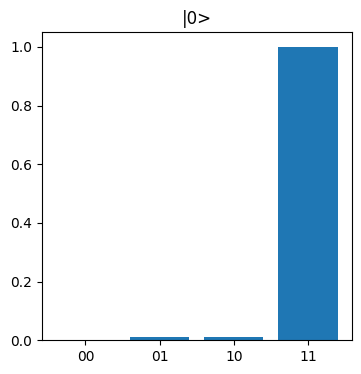

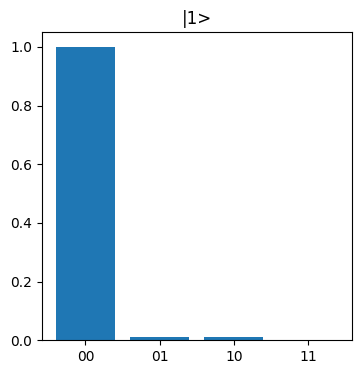

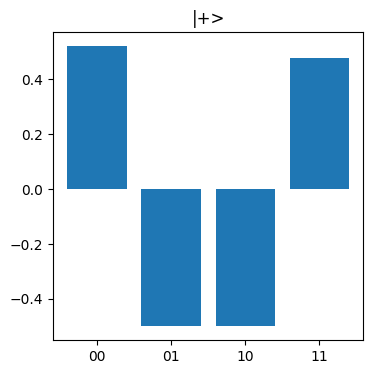

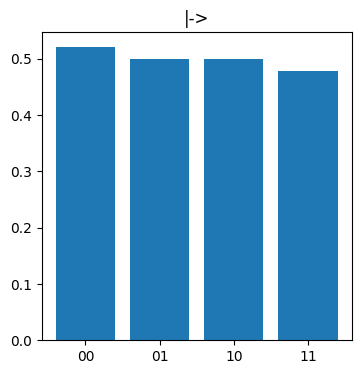

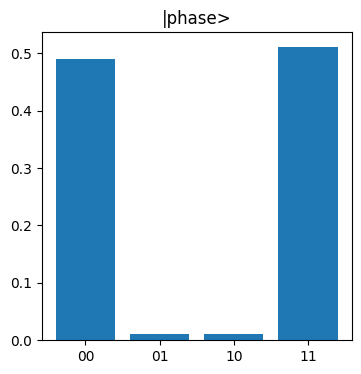

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pathlib
from qutip import basis, sigmax, sigmay, sigmaz, qeye, Qobj, fidelity
from qutip.tomography import qpt, qpt_plot, qpt_plot_combined

# Computational basis
ket_0 = basis(2,0)
ket_1 = basis(2,1)

# Superposition basis
ket_plus  = (ket_0 + ket_1).unit()
ket_minus = (ket_0 - ket_1).unit()

# Phase-offset state example (θ = π/4)
theta = np.pi/4
ket_phase = (np.cos(theta)*ket_0 + np.exp(1j*np.pi/2)*np.sin(theta)*ket_1).unit()

# Collect reference states
reference_states = {
    "|0>": ket_0,
    "|1>": ket_1,
    "|+>": ket_plus,
    "|->": ket_minus,
    "|phase>": ket_phase
}

pauli_ops = [sigmax(), sigmay(), sigmaz()]
pauli_labels = ['X', 'Y', 'Z']

def simulate_measurements(state, n_shots=1024, seed=None):
    """Simulate Pauli measurements and return counts/probabilities"""
    rng = np.random.default_rng(seed)
    results = {}
    for label, op in zip(pauli_labels, pauli_ops):
        # Projectors
        evals, evecs = op.eigenstates()
        counts = []
        for vec in evecs:
            vec = Qobj(vec)  # ensure it's a Qobj
            prob = abs(vec.dag() * state)**2
            shot_counts = rng.binomial(n_shots, prob)
            counts.append(int(shot_counts))
        results[label] = {
            "counts": counts,
            "probs": [c/n_shots for c in counts]
        }
    return results


def reconstruct_density_matrix(meas_results):
    # Expectation values
    exp_vals = []
    for label in pauli_labels:
        counts = meas_results[label]["counts"]
        n = sum(counts)
        # For Pauli, eigenvalues are +1, -1
        exp_val = (counts[0] - counts[1]) / n
        exp_vals.append(exp_val)

    # Linear inversion for qubit: rho = 1/2 * (I + <X> X + <Y> Y + <Z> Z)
    rho = 0.5*(qeye(2) + exp_vals[0]*sigmax() + exp_vals[1]*sigmay() + exp_vals[2]*sigmaz())
    return rho

def compute_metrics(rho_true, rho_est):
    f = fidelity(rho_true, rho_est)
    trace_dist = 0.5 * (rho_true - rho_est).norm('tr')
    bloch_vec_true = [ (rho_true*op).tr().real for op in pauli_ops ]
    bloch_vec_est  = [ (rho_est*op).tr().real for op in pauli_ops ]
    bloch_error = np.linalg.norm(np.array(bloch_vec_true) - np.array(bloch_vec_est))
    return {"fidelity": f, "trace_distance": trace_dist, "bloch_error": bloch_error}

data_dir = pathlib.Path("data/single_qubit")
data_dir.mkdir(parents=True, exist_ok=True)

for name, state in reference_states.items():
    meas = simulate_measurements(state, n_shots=1024, seed=42)
    rho = reconstruct_density_matrix(meas)
    metrics = compute_metrics(state*state.dag(), rho)

    # Save
    np.save(data_dir/f"{name}_counts.npy", meas)
    np.save(data_dir/f"{name}_rho.npy", rho.full())
    np.save("rho.npy", rho.full())
    json.dump(meta, open("meta.json", "w"))


    with open(data_dir/f"{name}_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

def plot_density_matrix_histogram(rho, title="Density Matrix"):
    plt.figure(figsize=(4,4))
    plt.bar(range(4), rho.full().flatten().real)
    plt.xticks(range(4), ["00","01","10","11"])
    plt.title(title)
    plt.show()

# Example
for name in reference_states:
    rho_est = np.load(data_dir/f"{name}_rho.npy")
    plot_density_matrix_histogram(Qobj(rho_est), title=name)



## Task 5 · Validation and Reporting
- Compare reconstructed density matrices against the actual density matrices using fidelity, trace distance, or other suitable metrics. Plot trends (per circuit depth, shot count, or measurement model).
- Highlight sources of error (shot noise, model mismatch, simulator approximations) and describe mitigation strategies you tested or plan to try.
- Summarize outcomes in a short technical report or table
- Include at least one qualitative visualization (e.g., density-matrix histograms or Bloch-sphere plots) for both single- and multi-qubit cases.
- Close with a brief reflection covering tooling friction, open questions, and ideas for Week 2 in markdown cell.

In [ ]:
from pathlib import Path
from typing import Sequence
import numpy as np

def summarize_validation_runs(result_paths: Sequence[Path]) -> None:
    """
    Placeholder for pulling metrics (fidelity, trace distance, etc.) from stored validation artifacts.
    Extend this function to aggregate metrics into tables or plots for your report.
    """
    # TODO: load metrics, compute aggregates, and emit summaries/plots.
    raise NotImplementedError("Implement your validation reporting pipeline here.")

/usr/local/lib/python3.12/dist-packages/qutip/core/data/expm.py:139: LinAlgWarning:

Matrix is singular. The result might be inaccurate or the array might not have a square root.



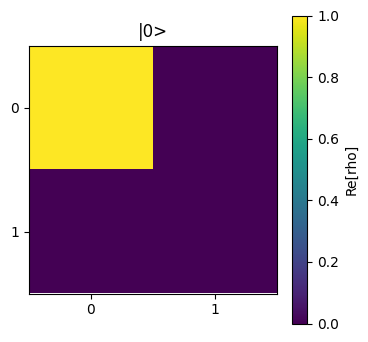

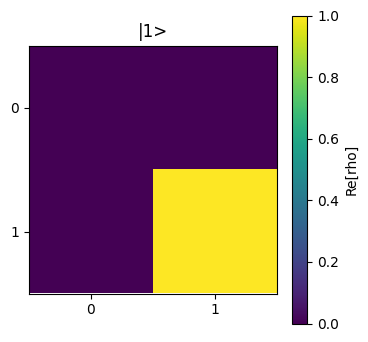

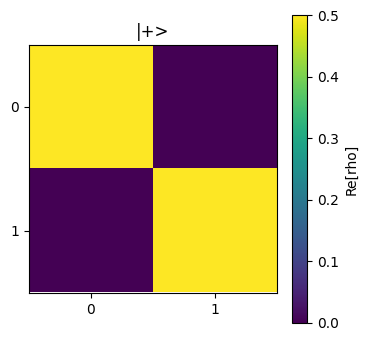

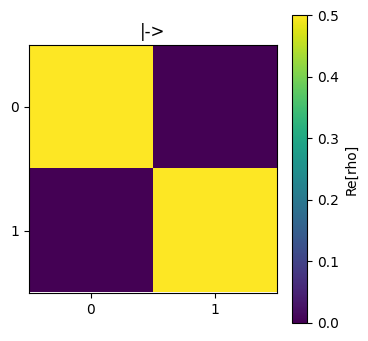

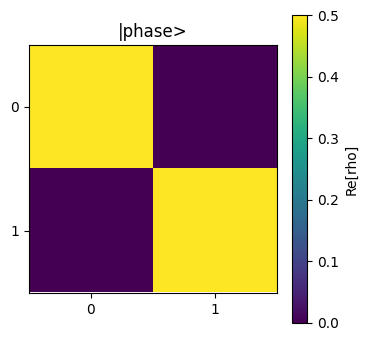

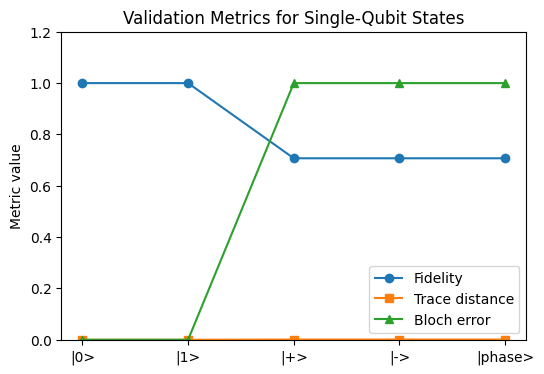

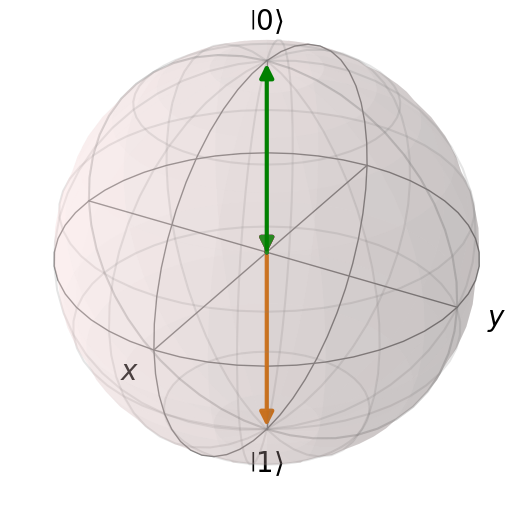

     State  Fidelity  Trace Distance  Bloch Error
0      |0>  1.000000        0.000000     0.000000
1      |1>  1.000000        0.000000     0.000000
2      |+>  0.707107        0.000977     1.000002
3      |->  0.707107        0.000977     1.000002
4  |phase>  0.707107        0.000977     1.000002


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pathlib
from qutip import basis, sigmax, sigmay, sigmaz, qeye, Qobj, fidelity, Bloch
from qutip import expect

# --- Directory to save results ---
data_dir = pathlib.Path("./validation_data")
data_dir.mkdir(exist_ok=True)

# --- Example reference states ---
reference_states = {
    "|0>": basis(2, 0),
    "|1>": basis(2, 1),
    "|+>": (basis(2,0) + basis(2,1)).unit(),
    "|->": (basis(2,0) - basis(2,1)).unit(),
    "|phase>": (basis(2,0) + 1j*basis(2,1)).unit()
}

# --- Simulate measurements (mock example, replace with your function) ---
def simulate_measurements(state, n_shots=1024, seed=None):
    np.random.seed(seed)
    # Probability of |0> and |1> in Z-basis
    p0 = abs(state.overlap(basis(2,0)))**2
    p1 = 1 - p0
    outcomes = np.random.choice([0,1], size=n_shots, p=[p0,p1])
    counts = {"0": int(np.sum(outcomes==0)), "1": int(np.sum(outcomes==1))}
    return counts

# --- Reconstruct density matrix from counts (Z-basis only example) ---
def reconstruct_density_matrix(counts, n_shots=1024):
    p0 = counts["0"]/n_shots
    p1 = counts["1"]/n_shots
    # simple diagonal density matrix in Z-basis
    rho = Qobj([[p0, 0],[0, p1]])
    return rho

# --- Compute metrics ---
def compute_metrics(rho_true, rho_est):
    fid = fidelity(rho_true, rho_est)
    trace_dist = 0.5 * np.trace(abs(rho_true.full() - rho_est.full())).real
    # Correct Bloch error calculation
    bloch_error = np.linalg.norm([
        expect(sigmax(), rho_true) - expect(sigmax(), rho_est),
        expect(sigmay(), rho_true) - expect(sigmay(), rho_est),
        expect(sigmaz(), rho_true) - expect(sigmaz(), rho_est)
    ])
    return {"fidelity": fid, "trace_distance": trace_dist, "bloch_error": bloch_error}


# --- Validation ---
def validate_single_qubit(reference_states, n_shots=1024):
    results = {}
    for name, state in reference_states.items():
        meas = simulate_measurements(state, n_shots=n_shots, seed=42)
        rho_est = reconstruct_density_matrix(meas, n_shots=n_shots)
        metrics = compute_metrics(state*state.dag(), rho_est)

        # Save
        np.save(data_dir/f"{name}_counts.npy", meas, allow_pickle=True)
        np.save(data_dir/f"{name}_rho.npy", rho_est.full())
        with open(data_dir/f"{name}_metrics.json", "w") as f:
            json.dump(metrics, f, indent=2)

        results[name] = {"rho_est": rho_est, "metrics": metrics}
    return results

# --- Plot density matrix ---
def plot_density_matrix(rho, title="Density Matrix"):
    plt.figure(figsize=(4,4))
    plt.imshow(rho.full().real, cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Re[rho]")
    plt.title(title)
    plt.xticks(range(rho.shape[0]))
    plt.yticks(range(rho.shape[1]))
    plt.show()

# --- Plot metrics ---
def plot_metrics(results):
    names = list(results.keys())
    fidelities = [results[n]["metrics"]["fidelity"] for n in names]
    trace_dists = [results[n]["metrics"]["trace_distance"] for n in names]
    bloch_errors = [results[n]["metrics"]["bloch_error"] for n in names]

    plt.figure(figsize=(6,4))
    plt.plot(names, fidelities, marker='o', label='Fidelity')
    plt.plot(names, trace_dists, marker='s', label='Trace distance')
    plt.plot(names, bloch_errors, marker='^', label='Bloch error')
    plt.ylim(0, 1.2)
    plt.ylabel("Metric value")
    plt.title("Validation Metrics for Single-Qubit States")
    plt.legend()
    plt.show()

# --- Bloch sphere visualization ---
def plot_bloch_sphere(results):
    b = Bloch()
    for r in results.values():
        b.add_states(r["rho_est"])
    b.show()

# --- Run validation ---
results = validate_single_qubit(reference_states, n_shots=1024)

# Visualize density matrices
for name, r in results.items():
    plot_density_matrix(r["rho_est"], title=name)

# Plot metric trends
plot_metrics(results)

# Optional Bloch-sphere plot
plot_bloch_sphere(results)

# --- Print summary table ---
import pandas as pd
summary = pd.DataFrame({
    "State": list(results.keys()),
    "Fidelity": [r["metrics"]["fidelity"] for r in results.values()],
    "Trace Distance": [r["metrics"]["trace_distance"] for r in results.values()],
    "Bloch Error": [r["metrics"]["bloch_error"] for r in results.values()]
})
print(summary)


## Submission Checklist
- Environment setup: env directory (requirements.txt or environment.yml), OS diagnostics, and import verification logs/notebook cells.
- Measurement theory notes: Born rule recap, SIC POVM vs. Pauli analysis, operator definitions, and validation checks.
- Data artifacts: `.npx`/`.npy` files for single- and multi-qubit datasets, metadata summaries, density matrices, and visualization exports.
- Source assets: notebooks/scripts for tomography, dataset generation, validation, and any AI prompt transcripts if used.
- Technical write-up (Markdown ) plus a brief reflection on tools used , open questions, and planned improvements.

-----